In [141]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from datetime import datetime as dt

FIGSIZE = (20, 6)

In [76]:
years = [i.name for i in os.scandir(f"inmet-data") if i.is_dir()]
location = "A801"

filenames = []
for year in years[1:]:
    filenames.extend(
        [
            f"{year}/{file.name}"
            for file in os.scandir(f"inmet-data/{year}")
            if location in file.name
        ]
    )

filenames.sort()

dfs = []
for f in filenames:
    df = pd.read_csv(f"inmet-data/{f}", delimiter=";", header=8, encoding="iso-8859-1")
    dfs.append(
        df.rename(
            columns={
                "HORA (UTC)": "Hora UTC",
                "DATA (YYYY-MM-DD)": "Data",
                "RADIACAO GLOBAL (Kj/m²)": "RADIACAO GLOBAL (KJ/m²)",
            }
        )
    )

raw_data = pd.concat(dfs).reset_index()
raw_data

,index,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,0,2000-09-22,00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
1,1,2000-09-22,01:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
2,2,2000-09-22,02:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
3,3,2000-09-22,03:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
4,4,2000-09-22,04:00,0,"1013,9","1014,2","1013,2",-9999,"15,5","14,6",...,"15,5","14,8","14,6",95.0,94.0,94.0,231.0,"4,4","1,2",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200371,5107,2024/07/31,1900 UTC,0,"1014,8","1014,9","1014,8","1501,3","22,5","12,2",...,"22,4",13,"11,1",54.0,46.0,52.0,79.0,"3,4","1,2",NaN
200372,5108,2024/07/31,2000 UTC,0,"1014,2","1014,8","1014,2",642,"21,5","11,9",...,"21,5","12,8","11,4",56.0,49.0,54.0,92.0,"3,6","1,1",NaN
200373,5109,2024/07/31,2100 UTC,0,"1014,4","1014,4","1014,2","50,8","18,9","12,5",...,"18,9","12,5","11,7",66.0,54.0,66.0,129.0,"3,1","1,1",NaN
200374,5110,2024/07/31,2200 UTC,0,"1014,7","1014,7","1014,4",NaN,"17,8","13,5",...,"17,7","13,5","12,5",76.0,66.0,76.0,111.0,"3,2",1,NaN


In [130]:
cols = raw_data.columns

# treating hour data bc it's not super consistent
raw_data[cols[2]] = raw_data[cols[2]].apply(
    lambda s: ":".join([s[:2], s[2:4]]) if isinstance(s, str) and "UTC" in s else s
)
# same for dates
raw_data[cols[1]] = raw_data[cols[1]].apply(
    lambda s: s.replace("/", "-") if isinstance(s, str) else s
)


raw_data["datetime"] = pd.to_datetime(
    raw_data[cols[1]] + " " + raw_data[cols[2]], format="%Y-%m-%d %H:%M"
)


def parseToFloat(col):
    return (
        raw_data[col]
        .apply(lambda x: np.float64(x.replace(",", ".")) if (isinstance(x, str)) else x)
        .apply(lambda x: np.nan if x == -9999.0 else x)
    )


# global-radiation
raw_data["global-radiation"] = parseToFloat(cols[7])

# precipitation
raw_data["total-precipitation"] = parseToFloat(cols[3])

raw_data["relative-humidity"] = parseToFloat("UMIDADE RELATIVA DO AR, HORARIA (%)")

# temperature
raw_data["temperature-last-hour-max"] = parseToFloat(
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"
)
raw_data["temperature-last-hour-min"] = parseToFloat(
    "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"
)

# wind
raw_data["wind-speed"] = parseToFloat("VENTO, VELOCIDADE HORARIA (m/s)")
raw_data["wind-speed-max-gust"] = parseToFloat("VENTO, RAJADA MAXIMA (m/s)")

raw_data
# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.drop(columns=cols[:21]).set_index("datetime")
renamed_data["datetime"] = renamed_data.index
renamed_data

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,datetime
datetime,,,,,,,,
2000-09-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 00:00:00
2000-09-22 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 01:00:00
2000-09-22 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 02:00:00
2000-09-22 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 03:00:00
2000-09-22 04:00:00,NaN,0.0,94.0,15.6,15.5,1.2,4.4,2000-09-22 04:00:00
...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,1501.3,0.0,52.0,23.7,22.4,1.2,3.4,2024-07-31 19:00:00
2024-07-31 20:00:00,642.0,0.0,54.0,22.6,21.5,1.1,3.6,2024-07-31 20:00:00
2024-07-31 21:00:00,50.8,0.0,66.0,21.5,18.9,1.1,3.1,2024-07-31 21:00:00


In [241]:
target = "global-radiation"
idx = "datetime"

df = renamed_data

by_day = (
    renamed_data.groupby([df.index.year, df.index.day_of_year]).mean().set_index(idx)
)

by_day = by_day.loc[by_day[target].notna()]
by_day

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2000-09-22 11:30:00,1709.000000,0.000000,69.150000,17.645000,16.665000,1.830000,4.950000
2000-09-23 11:30:00,1621.166667,1.166667,76.125000,18.170833,16.875000,1.558333,4.529167
2000-09-24 11:30:00,519.857143,0.991667,80.750000,15.516667,14.641667,2.454167,7.358333
2000-09-25 11:30:00,1821.769231,0.000000,61.458333,11.275000,10.229167,2.733333,7.195833
2000-09-26 11:30:00,1838.307692,0.000000,63.458333,12.283333,11.295833,1.750000,4.679167
...,...,...,...,...,...,...,...
2024-07-27 11:30:00,571.772727,0.025000,90.583333,17.170833,16.529167,0.820833,2.675000
2024-07-28 11:30:00,166.763636,0.200000,94.875000,15.708333,15.366667,1.233333,4.470833
2024-07-29 11:30:00,294.172727,0.783333,88.708333,12.475000,11.945833,1.620833,6.629167


,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2000-09-22 11:30:00,1709.000000,0.000000,69.150000,17.645000,16.665000,1.830000,4.950000
2000-09-23 11:30:00,1621.166667,1.166667,76.125000,18.170833,16.875000,1.558333,4.529167
2000-09-24 11:30:00,519.857143,0.991667,80.750000,15.516667,14.641667,2.454167,7.358333
2000-09-25 11:30:00,1821.769231,0.000000,61.458333,11.275000,10.229167,2.733333,7.195833
2000-09-26 11:30:00,1838.307692,0.000000,63.458333,12.283333,11.295833,1.750000,4.679167
...,...,...,...,...,...,...,...
2017-12-27 11:30:00,2088.713333,0.000000,73.708333,26.187500,24.950000,1.375000,4.379167
2017-12-28 11:30:00,1630.253333,0.000000,80.250000,26.320833,24.916667,2.600000,6.300000
2017-12-29 11:30:00,1012.273333,0.675000,82.500000,25.304167,24.091667,1.782609,5.721739


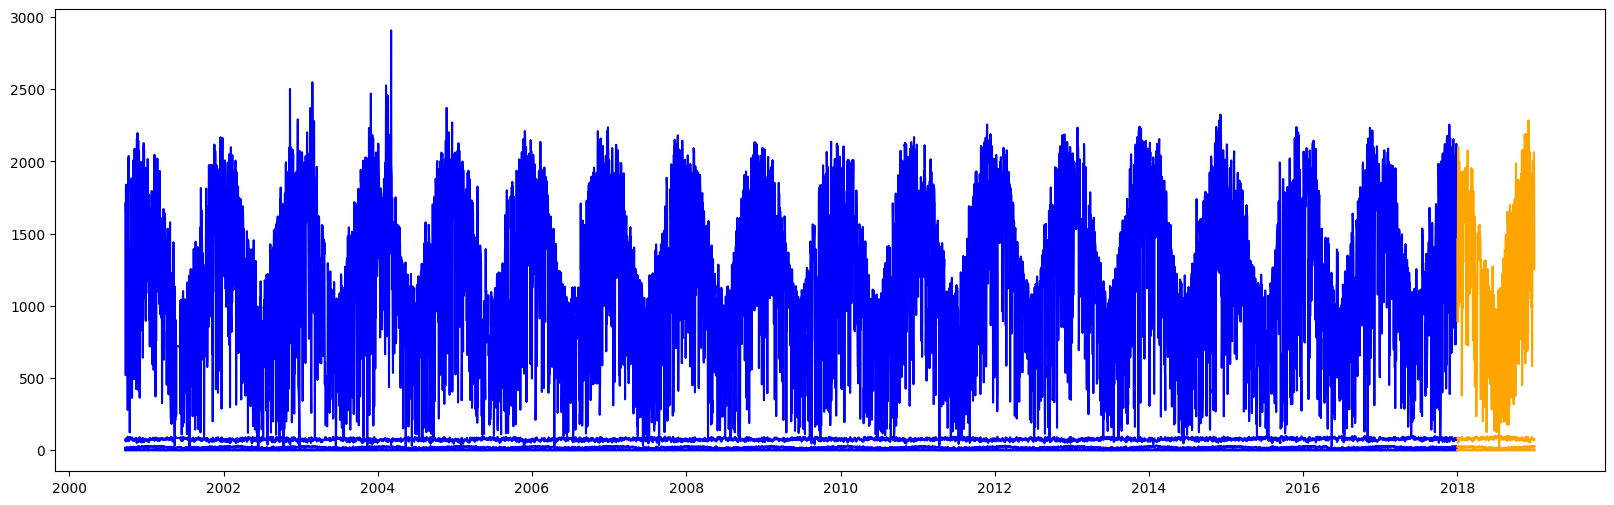

In [242]:
date_threshold, date_mask = "2018", "%Y"
date_upper_threshold = "2019"


def training_threshold(col):
    return col <= pd.to_datetime(date_threshold, format=date_mask)


def testing_treshold(col):
    return ~training_threshold(col) & (
        col <= pd.to_datetime(date_upper_threshold, format=date_mask)
    )


train = by_day[training_threshold(by_day.index)].dropna()
test = by_day[testing_treshold(by_day.index)].dropna()


plt.figure(figsize=FIGSIZE)
plt.plot(train, color="blue")
plt.plot(test, color="orange")

train

In [243]:
window_size = 28


def make_rolling_window(df):
    return df.rolling(window=window_size).mean().copy()


train_rolling = make_rolling_window(train)
test_rolling = make_rolling_window(test)

# plt.figure(figsize=FIGSIZE)
# plt.plot(test_rolling)
# plt.plot(train_rolling)
# plt.show()
train_rolling.corr()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
global-radiation,1.000000,-0.274236,-0.794248,0.830899,0.820088,0.572302,0.608080
total-precipitation,-0.274236,1.000000,0.440507,-0.161419,-0.151993,-0.038433,0.062312
relative-humidity,-0.794248,0.440507,1.000000,-0.578830,-0.564114,-0.565629,-0.504464
temperature-last-hour-max,0.830899,-0.161419,-0.578830,1.000000,0.999662,0.429573,0.445622
temperature-last-hour-min,0.820088,-0.151993,-0.564114,0.999662,1.000000,0.427443,0.443296
wind-speed,0.572302,-0.038433,-0.565629,0.429573,0.427443,1.000000,0.940107
wind-speed-max-gust,0.608080,0.062312,-0.504464,0.445622,0.443296,0.940107,1.000000


In [132]:
fit_data = pd.DataFrame(dict(ds=train_rolling.index, y=train_rolling[target]))
fit_data

from prophet import Prophet

reg = Prophet()
reg.fit(fit_data)

20:52:10 - cmdstanpy - INFO - Chain [1] start processing
20:52:11 - cmdstanpy - INFO - Chain [1] done processing


/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<bound method DataFrame.corr of                       ds        trend   yhat_lower   yhat_upper  trend_lower  \
0    2000-10-20 11:30:00  1119.299243  1003.390660  1274.360984  1119.299243   
1    2000-10-21 11:30:00  1119.276001  1011.359685  1279.805720  1119.276001   
2    2000-10-22 11:30:00  1119.252760  1011.668260  1290.309103  1119.252760   
3    2000-10-23 11:30:00  1119.229519  1022.902672  1301.020010  1119.229519   
4    2000-10-24 11:30:00  1119.206278  1027.137437  1303.015134  1119.206278   
...                  ...          ...          ...          ...          ...   
6658 2019-05-27 11:30:00  1227.987771   770.966848  1052.616916  1208.823069   
6659 2019-05-28 11:30:00  1228.034708   760.798967  1035.885997  1208.705752   
6660 2019-05-29 11:30:00  1228.081645   764.057143  1043.389275  1208.569456   
6661 2019-05-30 11:30:00  1228.128583   759.115161  1028.895236  1208.530381   
6662 2019-05-31 11:30:00  1228.175520   754.827713  1023.646978  1208.502647   

      t

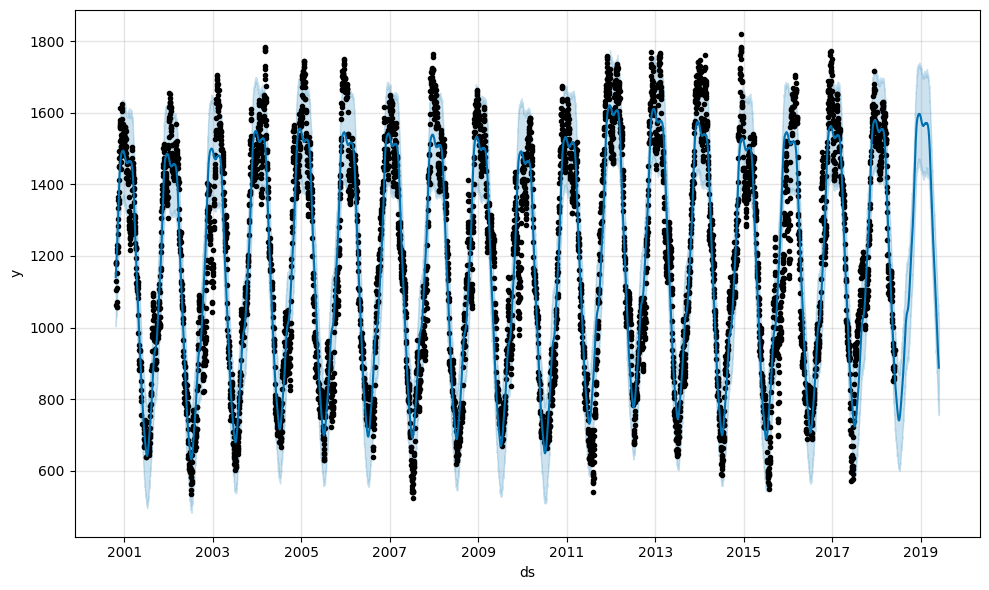

In [145]:
future = reg.make_future_dataframe(periods=365)
forecast = reg.predict(future)

reg.plot(forecast)
forecast.corr

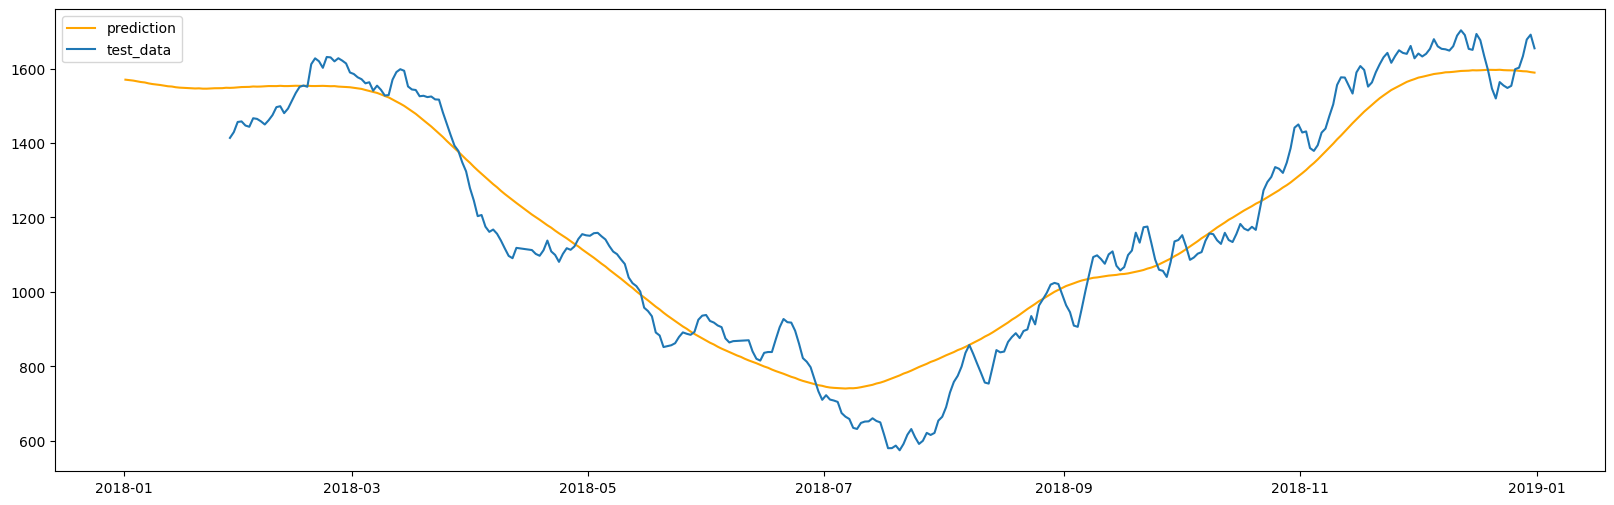

In [317]:
def period(col):
    return (col > pd.to_datetime(date_threshold, format=date_mask)) & (
        col < pd.to_datetime(date_upper_threshold, format=date_mask)
    )


prediction = forecast.loc[testing_treshold(forecast.ds), ["ds", "yhat"]]
rolling_test_compare = test_rolling.loc[testing_treshold(test.index)]
rolling_test_compare["doy"] = rolling_test_compare.index.day_of_year

plt.figure(figsize=FIGSIZE)
plt.plot(prediction.ds, prediction.yhat, color="orange", label="prediction")
plt.plot(rolling_test_compare[target], label="test_data")
plt.legend()

<Axes: xlabel='doy'>

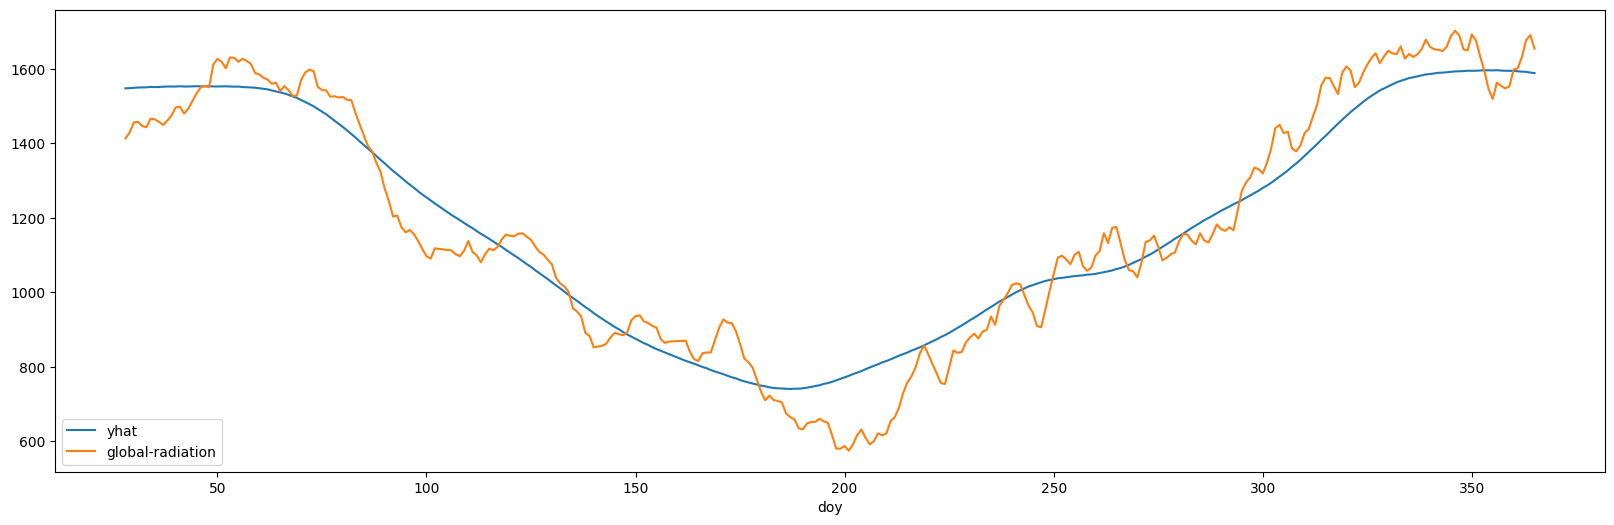

In [365]:
prediction_renamed = pd.DataFrame(
    {"doy": prediction.ds.apply(lambda d: d.day_of_year), "yhat": prediction.yhat}
)
comparison = rolling_test_compare.merge(prediction_renamed, on="doy")
comparison = comparison.loc[
    (comparison.yhat.notna()) & (comparison["global-radiation"].notna()),
    ["doy", "yhat", target],
].set_index("doy")

comparison.plot(figsize=FIGSIZE)

In [323]:
from sklearn.metrics import mean_absolute_percentage_error as mape

error = mape(comparison[target], comparison.yhat)
f"predition error is {error:.3f}%"

'predition error is 0.067%'

,historic,last year
27,1516.934077,1413.841820
28,1514.315511,1429.352432
29,1520.296934,1456.636003
30,1517.538662,1458.140289
31,1517.090773,1447.114269
...,...,...
354,1544.689327,1602.519396
355,1545.301482,1633.418444
356,1548.305052,1678.195587
357,1549.833830,1691.253622


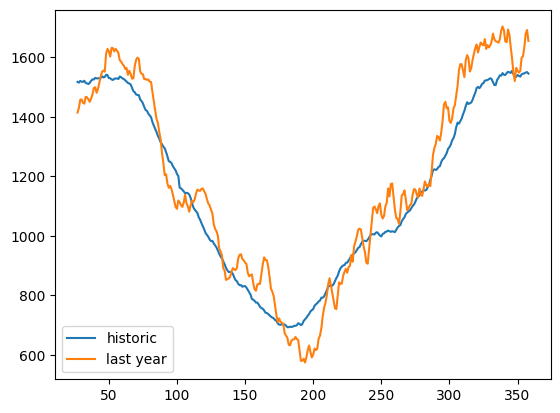

In [360]:
all_years = by_day
all_years["doy"] = by_day.index.day_of_year

all_years = make_rolling_window(all_years.groupby("doy").mean()[[target]])

compare_col_names = {f"{target}_x": "historic", f"{target}_y": "last year"}
comparison_simple = all_years.merge(rolling_test_compare, on="doy").rename(
    columns=compare_col_names
)

comparison_simple = comparison_simple.loc[
    (comparison_simple.historic.notna()) & (comparison_simple["last year"].notna()),
    [i for i in compare_col_names.values()],
]

comparison_simple.plot(figsize=FIGSIZE)
error_simple = mape(*[comparison_simple[i] for i in compare_col_names.values()])
f"predition error is {error_simple:.3f}%"

'predition error is 0.068%'

'predition error is 0.036%'

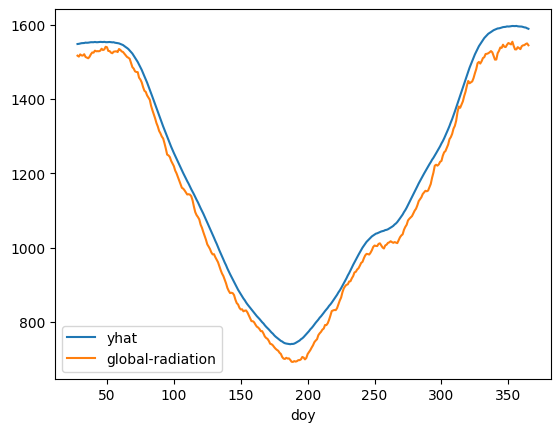

In [363]:
comparison_test = all_years.merge(prediction_renamed, on="doy").rename(
    columns=compare_col_names
)
comparison_test = comparison_test.loc[
    (comparison_test.yhat.notna()) & (comparison_test["global-radiation"].notna()),
    ["doy", "yhat", target],
].set_index("doy")

comparison_test.plot(figsize=FIGSIZE)
error_test = mape(*[comparison_test[i] for i in comparison_test.columns])
f"predition error is {error_test:.3f}%"